In [12]:
import torch
import torch.nn as nn
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import binned_statistic

from models import CFM
from models import Classifier
from gaussian_toy import GaussianToy
from plots import plot_naive_unfold, plot_reweighted_distribution, plot_prior_unfold

Create Gaussian toy example. Define six datasets:
1. Reco-level simulation
2. Gen-level simulation
3. Background simulation
4. Reco-level data
5. Gen-level data
6. Background data

In [13]:
data_params = { "n_dim": 1,
                "n_mc": 1000000,
                "mc_mu": 0,
                "mc_sigma": 1,
                "n_data": 1000000,
                "data_mu": 0.2,
                "data_sigma": 0.8,
                "detector_mu": 0,
                "detector_sigma": 0.5,
                "n_background": 100000,
                "background_mu": 0,
                "background_sigma": 1.2,
                "mc_rec_cut": True,
                "mc_gen_cut": True,
                "data_rec_cut": True,
                "data_gen_cut":True ,
                "rec_cut_position": 1.2,
                "gen_cut_position":1.2
}

In [14]:
ToyModel = GaussianToy(data_params)

Define background subtraction classifier

In [15]:
bkg_true = torch.cat([ToyModel.data_rec[ToyModel.data_rec_mask.bool()], ToyModel.mc_background_rec[ToyModel.mc_background_mask.bool()]])
weights_true = torch.cat([torch.ones_like(ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()]), torch.ones_like( ToyModel.mc_background_rec[ToyModel.mc_background_mask.bool()][:,0]) * -1])
bkg_false = ToyModel.data_rec[ToyModel.data_rec_mask.bool()]
weights_false = torch.ones_like(bkg_false[:,0])

In [16]:
background_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [17]:
background_classifier = Classifier(1, background_classifier_params)

In [18]:
background_classifier.train_classifier(bkg_true, bkg_false, weights_true, weights_false)

Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2645364999771118 after time 7.9
    Finished epoch 6 with average loss 1.2641788721084595 after time 55.5
    Finished epoch 12 with average loss 1.264338493347168 after time 103.4
    Finished epoch 18 with average loss 1.2639726400375366 after time 153.1
    Finished epoch 24 with average loss 1.2642163038253784 after time 202.3
    Finished epoch 29 with average loss 1.264177680015564 after time 241.8


In [20]:
background_weights = background_classifier.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()])
background_weights = background_weights * len(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()])/ background_weights.sum()

In [21]:
with PdfPages(f"Plots/background_suppression_cut.pdf") as out:
    plot_reweighted_distribution(out, ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:-100000].bool()],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], reweighted_weights=background_weights,
                                 range=[-3,4], labels=[r"$\text{signal} |_r$" , "reweighted","data $(s+b)|_r$"], name="x_1")

/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:165: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:166: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)


Define acceptance classifier

In [22]:
acceptance_true = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
acceptance_false = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & ~(ToyModel.mc_gen_mask.bool())]

In [23]:
acceptance_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [24]:
acceptance_classifier = Classifier(1, acceptance_classifier_params)

In [25]:
acceptance_classifier.train_classifier(acceptance_true, acceptance_false, balanced=False)

    Training with unbalanced training set with weight 31.51449247906642
Training classifier for 930 epochs with lr 0.0001
    Finished epoch 0 with average loss 13.304145812988281 after time 0.3
    Finished epoch 186 with average loss 3.070875644683838 after time 43.3
    Finished epoch 372 with average loss 3.074319839477539 after time 86.9
    Finished epoch 558 with average loss 3.071563482284546 after time 132.5
    Finished epoch 744 with average loss 3.070725679397583 after time 178.3
    Finished epoch 929 with average loss 3.0648467540740967 after time 222.5


In [26]:
acceptance = acceptance_classifier.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()], return_weights=False)

In [27]:
with PdfPages(f"Plots/acceptance_effects_cuts.pdf") as out:
    plot_reweighted_distribution(out, ToyModel.data_signal_rec[:,0][(ToyModel.data_rec_mask[:-100000].bool()) & (ToyModel.data_gen_mask.bool())],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], reweighted_weights=acceptance*background_weights,
                                 fake_weights=background_weights,
                                 range=[-3,4], labels=[r"$\text{signal}|_{g,r}$" , "$\epsilon$ (data -b)","data -b"], name="x_1")

/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:165: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:166: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)


Train CFM unfolding network

In [28]:
iterative_unfolding_params = { "iterations" : 5,
                               "generator": { "hidden_layers": 4,
                                            "internal_size": 64,
                                            "lr": 1.e-4,
                                            "n_epochs" : 30,
                                            "batch_size" : 128,
                                            "batch_size_sample": 2000},
                               "classifier": {"hidden_layers": 4,
                                            "internal_size": 64,
                                            "lr": 1.e-4,
                                            "n_epochs" : 30,
                                            "batch_size" : 128,
                                            "batch_size_sample": 2000}}

Starting with the 0.iteration.
Initalize unfolder
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.7186583280563354 after time 4.9
    Finished epoch 6 with average loss 0.6727806329727173 after time 33.4
    Finished epoch 12 with average loss 0.6721792817115784 after time 62.8
    Finished epoch 18 with average loss 0.6721005439758301 after time 91.6
    Finished epoch 24 with average loss 0.6715049743652344 after time 120.4
    Finished epoch 29 with average loss 0.668695867061615 after time 144.1
unfold data


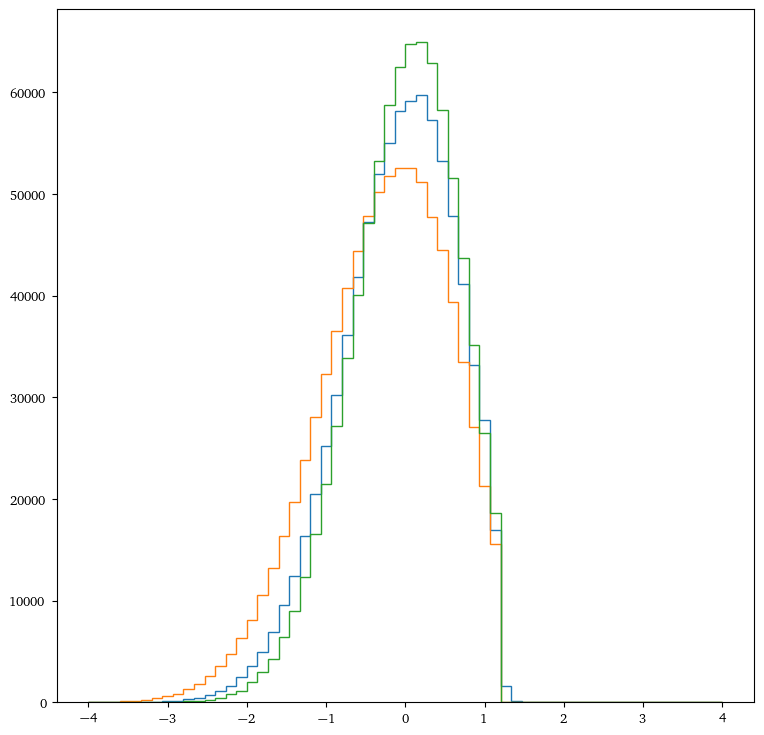

Starting with the 1.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2816290855407715 after time 6.8
    Finished epoch 6 with average loss 1.2803370952606201 after time 47.6
    Finished epoch 12 with average loss 1.2799090147018433 after time 88.6
    Finished epoch 18 with average loss 1.2799382209777832 after time 129.3
    Finished epoch 24 with average loss 1.279802680015564 after time 170.2
    Finished epoch 29 with average loss 1.2798163890838623 after time 204.6
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.5586714744567871 after time 4.8
    Finished epoch 6 with average loss 0.5578782558441162 after time 33.4
    Finished epoch 12 with average loss 0.5593376755714417 after time 61.9
    Finished epoch 18 with average loss 0.5586428642272949 after time 91.0
    Finished epoch 24 with average loss 0.558509886264801 after time 120.5
    Finished epoch 29 with average loss 0.558499097824096

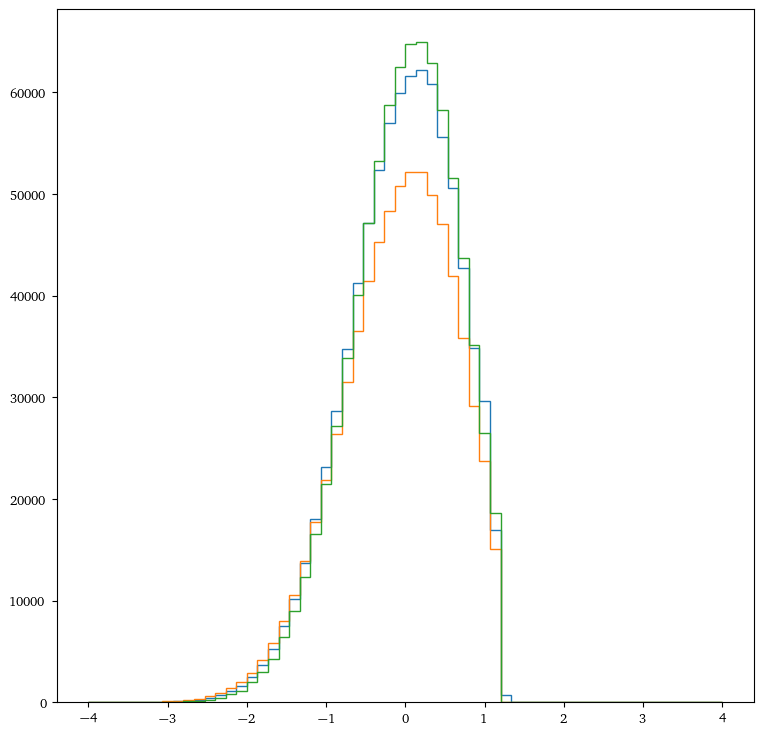

Starting with the 2.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2058566808700562 after time 6.9
    Finished epoch 6 with average loss 1.2058161497116089 after time 47.5
    Finished epoch 12 with average loss 1.2054303884506226 after time 88.1
    Finished epoch 18 with average loss 1.2053508758544922 after time 128.5
    Finished epoch 24 with average loss 1.2052891254425049 after time 169.1
    Finished epoch 29 with average loss 1.2053346633911133 after time 203.0
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.5613613128662109 after time 4.8
    Finished epoch 6 with average loss 0.5617164969444275 after time 33.7
    Finished epoch 12 with average loss 0.5612204074859619 after time 63.1
    Finished epoch 18 with average loss 0.5604472756385803 after time 91.8
    Finished epoch 24 with average loss 0.5631265044212341 after time 120.7
    Finished epoch 29 with average loss 0.5605211257934

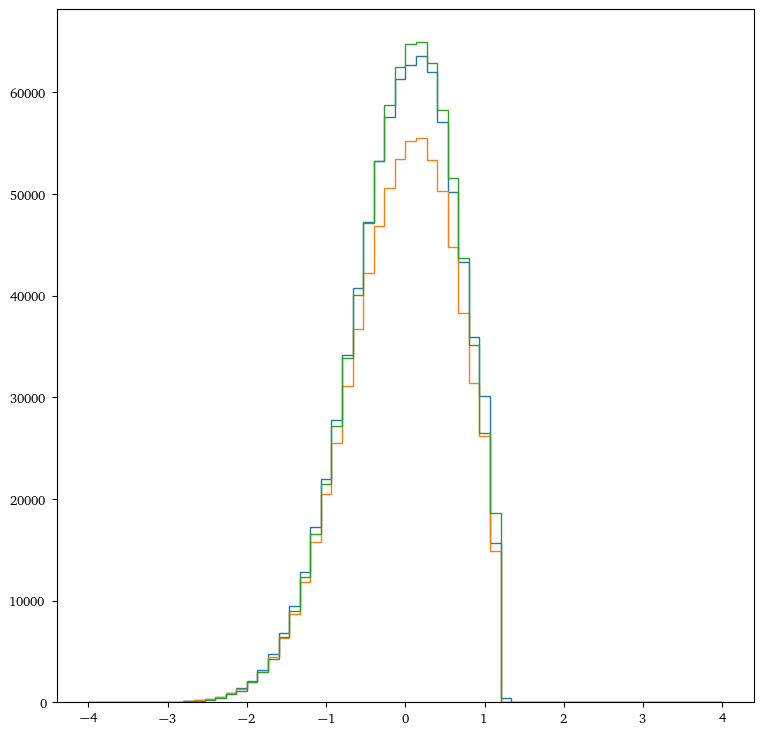

Starting with the 3.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2186686992645264 after time 7.1
    Finished epoch 6 with average loss 1.2186616659164429 after time 47.8
    Finished epoch 12 with average loss 1.2183661460876465 after time 88.6
    Finished epoch 18 with average loss 1.2183423042297363 after time 129.5
    Finished epoch 24 with average loss 1.2183676958084106 after time 170.2
    Finished epoch 29 with average loss 1.21834397315979 after time 204.0
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.556492269039154 after time 4.7
    Finished epoch 6 with average loss 0.5545641183853149 after time 33.2
    Finished epoch 12 with average loss 0.5548813939094543 after time 61.9
    Finished epoch 18 with average loss 0.5551694631576538 after time 90.6
    Finished epoch 24 with average loss 0.5538893938064575 after time 119.3
    Finished epoch 29 with average loss 0.5542430877685547

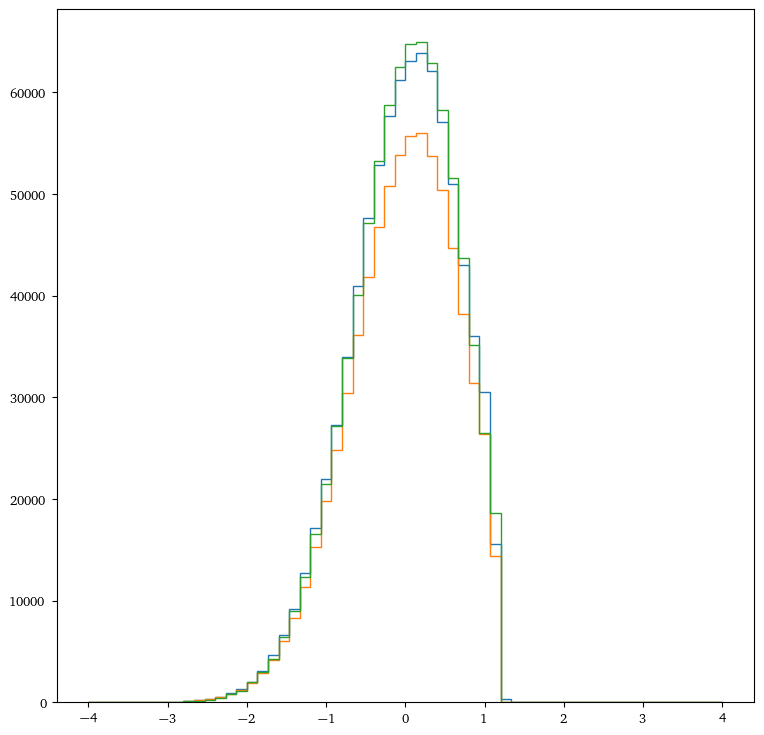

Starting with the 4.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2153195142745972 after time 6.9
    Finished epoch 6 with average loss 1.2153240442276 after time 47.6
    Finished epoch 12 with average loss 1.2151588201522827 after time 88.3
    Finished epoch 18 with average loss 1.2151107788085938 after time 129.2
    Finished epoch 24 with average loss 1.2151007652282715 after time 170.4
    Finished epoch 29 with average loss 1.2151391506195068 after time 204.2
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.5535871982574463 after time 4.7
    Finished epoch 6 with average loss 0.5547158718109131 after time 33.5
    Finished epoch 12 with average loss 0.553585946559906 after time 62.2
    Finished epoch 18 with average loss 0.5551121830940247 after time 90.7
    Finished epoch 24 with average loss 0.5545448064804077 after time 119.3
    Finished epoch 29 with average loss 0.5552684664726257 

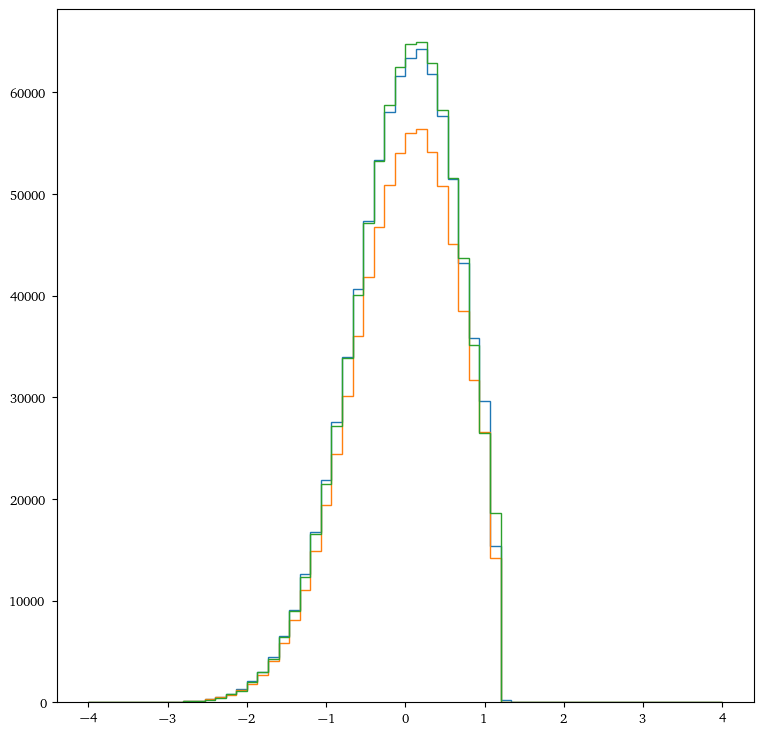

In [29]:
for i in range(iterative_unfolding_params["iterations"]):
    print(f"Starting with the {i}.iteration.")
    if i == 0:
        print("Initalize unfolder")
        unfolder = CFM(1, 1, iterative_unfolding_params["generator"])
        mc_gen = ToyModel.mc_gen[(ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())]
        mc_rec = ToyModel.mc_rec[(ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())]
        mc_weights = torch.ones_like(mc_rec[:, 0])
        data_weights = acceptance * background_weights
    if i > 0 :
        iterative_classifier = Classifier(1, iterative_unfolding_params["classifier"])
        iterative_classifier.train_classifier(data_unfold, mc_gen, data_weights, mc_weights)
        mc_weights *= iterative_classifier.evaluate(mc_gen)
    unfolder.train_unfolder(mc_gen, mc_rec, mc_weights)
    print("unfold data")
    data_unfold = unfolder.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()])
    fig, axes = plt.subplots()
    axes.hist(data_unfold[:,0], weights=data_weights, bins=60, histtype="step", range=[-4,4])
    axes.hist(mc_gen[:,0], weights=mc_weights, bins=60, histtype='step', range=[-4,4])
    axes.hist(ToyModel.data_gen[:,0][(ToyModel.data_rec_mask[:-100000].bool())&(ToyModel.data_gen_mask.bool())], bins=60, range=[-4,4], histtype="step")
    plt.show()

In [30]:
with PdfPages(f"Plots/prior_dependence_cut.pdf") as out:
    plot_prior_unfold(out, ToyModel.data_gen[:,0][(ToyModel.data_rec_mask[:-100000].bool()) & (ToyModel.data_gen_mask.bool())],ToyModel.mc_gen[:,0][(ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())],
                                 data_unfold[:, 0],
                      unfolded_weights=acceptance*background_weights,
                                 range=[-3,4], name="x_1")

/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:272: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:273: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:272: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])


Train efficiency classifier

In [31]:
efficiency_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [32]:
efficiency_true = ToyModel.mc_gen[(ToyModel.mc_rec_mask.bool()) ]
efficiency_false = ToyModel.mc_gen[~(ToyModel.mc_rec_mask.bool()) ]

In [33]:
efficiency_classifier = Classifier(1, efficiency_classifier_params)

In [34]:
efficiency_classifier.train_classifier(efficiency_true, efficiency_false, balanced=False)

    Training with unbalanced training set with weight 6.0499488878705625
Training classifier for 180 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.7235252857208252 after time 1.4
    Finished epoch 36 with average loss 1.2884454727172852 after time 44.3
    Finished epoch 72 with average loss 1.2821872234344482 after time 87.3
    Finished epoch 108 with average loss 1.2891201972961426 after time 130.2
    Finished epoch 144 with average loss 1.2812715768814087 after time 172.6
    Finished epoch 179 with average loss 1.284303903579712 after time 213.5


In [35]:
efficiency = efficiency_classifier.evaluate(data_unfold, return_weights=False)

In [36]:
data_weights =acceptance* background_weights/ efficiency

In [37]:
with PdfPages(f"Plots/efficiency_effects_cut.pdf") as out:
    plot_reweighted_distribution(out, ToyModel.data_gen[:,0][(ToyModel.data_gen_mask.bool())],
                                 data_unfold[:,0],
                                 data_unfold[:,0],
                                 reweighted_weights=acceptance*background_weights/efficiency,
                                 fake_weights=acceptance*background_weights,
                                 range=[-3,4], labels=[r"$\text{gen}|_g$" , r"$\text{unfolded} / \delta$","unfolded"], name="x_1")

/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:165: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])


In [38]:
with PdfPages(f"Plots/final_unfolding_cut.pdf") as out:
    plot_naive_unfold(out, ToyModel.data_gen[:, 0][
       (ToyModel.data_gen_mask.bool())],
                       ToyModel.data_rec[:, 0],
                      data_unfold[:, 0],
                        unfolded_weights=data_weights,
                      range=[-3, 4], name="x_1")

/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:56: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:57: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:56: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
